# Red Light Camera Natural Experiment

Linear regression analysis of factors affecting red light crashes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import scipy.stats as stats
import seaborn as sns

# import dask
# import dask.dataframe as dd

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
#rlc_df = pd.read_sql_query('''SELECT * FROM daily_violations''', conn)
#ints_df = pd.read_sql_query('''SELECT * FROM intersection_chars''', conn)
#crash_df = pd.read_sql_query('''SELECT * FROM signal_crashes''', conn)


In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('all_hours',), ('int_startend',), ('intersection_chars',), ('hourly_congestion',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injur

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [5]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [6]:
# THis is all the cam violations with start and end dates
# I will combine this with the crash data

cam_df = pd.read_sql_query('''WITH v AS(SELECT d.year,
                                                d.month,
                                                d.day,
                                                d.intersection,
                                                dv.violations,
                                                dv.violation_date,
                                                DATE(d.year ||'-01-01','+'||(d.month-1)||' month','+'||(d.day-1)||' day') as date
                                            FROM all_hours as d
                                            LEFT JOIN daily_violations as dv
                                                ON d.year = dv.year
                                                AND d.month = dv.month
                                                AND d.day = dv.day
                                                AND d.intersection = dv.intersection
                                            ), 
                                            
                                    se AS(SELECT *
                                         FROM int_startend as se
                                    )
                                        
                                    SELECT  v.*,
                                            se.start,
                                            se.end
                                    FROM v
                                    LEFT JOIN se
                                        ON se.intersection = v.intersection
                                    WHERE date >= \'2017-09-01\'  
                                        AND date <= \'2021-02-01\'
                                    GROUP BY date, v.intersection
                                    ORDER BY date, v.intersection

                                    ''', conn)



In [7]:
cam_df.tail(50)

,year,month,day,intersection,violations,violation_date,date,start,end
197450,2021,2,1,MADISON AND WESTERN,1.0,2021-02-01 00:00:00,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00
197451,2021,2,1,MICHIGAN AND JACKSON,3.0,2021-02-01 00:00:00,2021-02-01,2018-02-05 00:00:00,2021-02-02 00:00:00
197452,2021,2,1,MICHIGAN AND ONTARIO,1.0,2021-02-01 00:00:00,2021-02-01,2018-02-05 00:00:00,2021-02-02 00:00:00
197453,2021,2,1,MILWAUKEE AND CENTRAL,1.0,2021-02-01 00:00:00,2021-02-01,2017-10-25 00:00:00,2021-02-02 00:00:00
197454,2021,2,1,MILWAUKEE AND DEVON,4.0,2021-02-01 00:00:00,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00
197455,2021,2,1,MILWAUKEE AND MONTROSE,NaN,None,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00
197456,2021,2,1,MONTROSE AND WESTERN,1.0,2021-02-01 00:00:00,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00
197457,2021,2,1,OGDEN AND KOSTNER,3.0,2021-02-01 00:00:00,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00
197458,2021,2,1,PERSHING AND WESTERN,NaN,None,2021-02-01,2016-01-02 00:00:00,2017-05-31 00:00:00
197459,2021,2,1,PETERSON AND WESTERN,1.0,2021-02-01 00:00:00,2021-02-01,2016-01-02 00:00:00,2021-02-02 00:00:00


In [8]:
crash_df = pd.read_sql_query('''SELECT * FROM signal_crashes''', conn)                                       
#violations_df = pd.read_sql_query('''SELECT * FROM daily_violations''', conn)  
#days_df = pd.read_sql_query('''SELECT * FROM all_hours''', conn)  

In [9]:
#days_df[days_df['intersection']=='111TH AND HALSTED']  # missing from all_hours??  Probably missing from int_df

Make sure the cam_df looks as expected?  Should see around 10k crashes and 180k entries.

In [10]:
cam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197500 entries, 0 to 197499
Data columns (total 9 columns):
year              197500 non-null int64
month             197500 non-null int64
day               197500 non-null int64
intersection      197500 non-null object
violations        179392 non-null float64
violation_date    179392 non-null object
date              197500 non-null object
start             196250 non-null object
end               196250 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 13.6+ MB


What does my crash_df look like?

In [11]:
#crash_df[crash_df['intersection']=='115TH AND HALSTED'].info()
print(len(cam_df))

197500


#### change my dates to datetime objects
Need to do this so we can do some date calculations to see which entries had the cameras on or off.

In [12]:
cam_df[['start', 'end']] = cam_df[['start', 'end']].apply(pd.to_datetime)
crash_df['crash_date'] = crash_df['crash_date'].apply(pd.to_datetime)

#### Make sure all my intersections have start-end dates.  I was originally missing a few

In [13]:
cam_df.isna().sum()  # one entry each accident with no violations/vio_date.  Days with no

year                  0
month                 0
day                   0
intersection          0
violations        18108
violation_date    18108
date                  0
start              1250
end                1250
dtype: int64

Looks like we are missing violations for cameras that are turned off.  Some of these will be our experiment.

In [14]:
print(cam_df[cam_df['start'].isna()]['intersection'].unique())
print(len(cam_df[cam_df['start'].isna()]['intersection'].unique()))

cam_df.dropna(subset=['start'], inplace=True)
print(cam_df[cam_df['start'].isna()]['intersection'].unique())
print(len(cam_df[cam_df['start'].isna()]['intersection'].unique()))

['CENTRAL AND MILWAUKEE']
1
[]
0


## Merge my DataFrames
Combine my camera info and crash info into a single df.  
Keep all of the cam_df info since it has all the date info.  Will join on

In [15]:
pd.options.display.max_rows = 200
all_df = cam_df.merge(crash_df, how='left', on=['year', 'month', 'day', 'intersection'])

In [16]:
all_df['date'] = all_df.apply(lambda x: datetime(int(x.year), int(x.month), int(x.day)), axis=1)

In [17]:
print(len(cam_df)) # should be same as all if everything merged properly
print(len(crash_df))
print(len(all_df))

print(len(crash_df.intersection.unique()))  
print(len(cam_df.intersection.unique()))

print(set(crash_df.intersection.unique()) - set(cam_df.intersection.unique()))  # missing very first one ???


196250
60677
196436
181
157
{'COTTAGE GROVE AND 95TH', 'HALSTED AND 83RD', None, 'MADISON AND CENTRAL', 'ASHLAND AND ARCHER', 'GARFIELD AND ASHLAND', 'BLUE ISLAND AND DAMEN', 'ELSTON AND FOSTER', '31ST AND CALIFORNIA', 'ASHLAND AND 47TH', 'CORNELL DRIVE AND 57TH', 'CENTRAL AND MILWAUKEE', 'KIMBALL AND LINCOLN', 'WESTERN AND PRATT', '83RD AND STONY ISLAND', 'HARLEM AND NORTHWEST HWY', 'HALSTED AND 63RD', 'ARCHER/NARRAGANSETT AND 55TH', 'PULASKI AND MONTROSE', 'WESTERN AND ARMITAGE', 'ASHLAND AND 63RD', 'JEFFERY AND 79TH', 'WESTERN AND 51ST', 'VINCENNES AND 111TH', 'ASHLAND AND DIVERSEY'}


In [18]:
all_df = all_df[all_df['date']>=datetime(2017,9,1)]

In [19]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196436 entries, 0 to 196435
Data columns (total 56 columns):
year                             196436 non-null int64
month                            196436 non-null int64
day                              196436 non-null int64
intersection                     196436 non-null object
violations                       179553 non-null float64
violation_date                   179553 non-null object
date                             196436 non-null datetime64[ns]
start                            196436 non-null datetime64[ns]
end                              196436 non-null datetime64[ns]
crash_record_id                  6497 non-null object
rd_no                            6493 non-null object
crash_date                       6497 non-null datetime64[ns]
posted_speed_limit               6497 non-null object
traffic_control_device           6497 non-null object
device_condition                 6497 non-null object
weather_condition              

In [20]:
pd.options.display.max_columns = 1000
#all_df[all_df['year'].isna()]
#all_df.iloc[535444]
all_df.year.unique()

array([2017, 2018, 2019, 2020, 2021])

In [21]:
# need to determine if crash occurred in or outside of cam on dates

def rlc_state(start, end, my_date):

    if (end - my_date).days >= 0 and (my_date - start).days >= 0:
        return 1
    elif (my_date - end).days > 0:
        return 0
    elif (start - my_date).days > 0:
        return 0
    else:
        return None

all_df['rlc_on'] = all_df.apply(lambda x: rlc_state(x.start, x.end, x.date), axis=1)

In [22]:
all_df[all_df['intersection']=='115TH AND HALSTED']

,year,month,day,intersection,violations,violation_date,date,start,end,crash_record_id,rd_no,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,crash_type,damage,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,lane_cnt,intersection_related_i,hit_and_run_i,crash_date_est_i,work_zone_i,work_zone_type,workers_present_i,hour,region_id,time,weekday,rlc_on
1,2017,9,1,115TH AND HALSTED,7.0,2017-09-01 00:00:00,2017-09-01,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
158,2017,9,2,115TH AND HALSTED,6.0,2017-09-02 00:00:00,2017-09-02,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
315,2017,9,3,115TH AND HALSTED,4.0,2017-09-03 00:00:00,2017-09-03,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
473,2017,9,4,115TH AND HALSTED,2.0,2017-09-04 00:00:00,2017-09-04,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
630,2017,9,5,115TH AND HALSTED,1.0,2017-09-05 00:00:00,2017-09-05,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195652,2021,1,28,115TH AND HALSTED,NaN,None,2021-01-28,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
195809,2021,1,29,115TH AND HALSTED,NaN,None,2021-01-29,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
195966,2021,1,30,115TH AND HALSTED,NaN,None,2021-01-30,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
196123,2021,1,31,115TH AND HALSTED,NaN,None,2021-01-31,2016-01-02,2017-10-26,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [23]:
all_df[(all_df['intersection']=='115TH AND HALSTED') & (all_df['crash_date'].notnull())][['crash_date', 'start', 'end', 'rlc_on']]

,crash_date,start,end,rlc_on
4086,2017-09-27 08:00:00,2016-01-02,2017-10-26,1
11785,2017-11-15 07:30:00,2016-01-02,2017-10-26,0
12570,2017-11-20 17:42:00,2016-01-02,2017-10-26,0
26399,2018-02-16 20:15:00,2016-01-02,2017-10-26,0
33940,2018-04-05 15:24:00,2016-01-02,2017-10-26,0
36142,2018-04-19 13:50:00,2016-01-02,2017-10-26,0
46201,2018-06-22 17:40:00,2016-01-02,2017-10-26,0
48873,2018-07-09 22:21:00,2016-01-02,2017-10-26,0
56417,2018-08-26 12:00:00,2016-01-02,2017-10-26,0
65533,2018-10-23 22:09:00,2016-01-02,2017-10-26,0


### Split my control and experiment groups

In [24]:
all_on = all_df[all_df['rlc_on']==1]

In [25]:
all_off = all_df[all_df['rlc_on']==0]

Initial look at how cam on/off compares with count of crashes and percent of intersection days with crashes

In [26]:
print('Cameras ON')
print('Crashes: {}, Days: {},  Crashes per day: {:.3f}'.format(all_on.crash_record_id.count(), 
                                                                     len(all_on), 
                                                                     all_on.crash_record_id.count()/len(all_on),))

print()
print('Cameras OFF')
print('Crashes: {}, Days: {},  Crashes per day: {:.3f}'.format(all_off.crash_record_id.count(), 
                                                                     len(all_off), 
                                                                     all_off.crash_record_id.count()/len(all_off)))




Cameras ON
Crashes: 6007, Days: 185914,  Crashes per day: 0.032

Cameras OFF
Crashes: 490, Days: 10522,  Crashes per day: 0.047


# Hypothesis testing

This is all entries where cameras were on vs. all entries where camera off.

In [27]:
np.random.seed(seed=0)

on = all_on['crash_record_id'].notnull()
off = all_off['crash_record_id'].notnull()

In [28]:
def ab_test(on, off, alpha):
    on_rate = on.mean()
    off_rate = off.mean()
    expected_off = on_rate * len(off)

    print('Cameras ON mean: {:.4f}'.format(on_rate))
    print('Cameras OFF mean: {:.4f}'.format(off_rate))
    print()

    print('Actual with rlc off:', off.sum())
    print('Expected with rlc off: {:.0f}'.format(expected_off))
    n = len(off)
    p = on_rate
    var = n * p * (1-p)
    std = np.sqrt(var)

    print()
    print('Standard deviation: {:.2f}'.format(std))  
    
    z_score = (off.sum() - expected_off)/std
    print('z score: {:.2f}'.format(z_score))
    
    print()
    p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
    print('P value: {:.5f}'.format(p_val))
    
    print()
    if p_val < alpha:
        print('REJECT the null hypothesis')
    else: 
        print('DO NOT REJECT the null hypothesis')
    
    

    
ab_test(on, off, 0.05)

Cameras ON mean: 0.0323
Cameras OFF mean: 0.0466

Actual with rlc off: 490
Expected with rlc off: 340

Standard deviation: 18.14
z score: 8.27

P value: 0.00000

REJECT the null hypothesis


We see many more crashes with cameras off.  This is our first indication that red light cameras affect crashes.

Double check using a binomial test and Fischer's Test

In [29]:

# binomial test
pval = stats.binom_test(off.sum(),n=len(off),p=on.mean())
print(pval)


oddsratio, pvalue = stats.fisher_exact([[on.sum(), len(on)-on.sum()], [off.sum(), len(off)-off.sum()]])
print(oddsratio, pvalue)

7.897531998958373e-15
0.6835983625553474 5.0272076688575147e-14


We would reject the null hypothesis using AB test or binomial test.  
First indication indicates that red light cameras are statistically significant in reducing crashes.

I worry that other factors might be at play.

# Hypothesis test with intersections of interest

It is possible that the previous AB test was misleading.  Only a small percentage of cameras actually have dates where they were turned on/off during the examined time period. 

In [43]:
# get cams that have a start date within the investigated period or an end date within it.
select_cams = all_df[((all_df['start'] > datetime(2017,9,1)) & (all_df['end'] > datetime(2017,9,1)))
                     | ((all_df['end'] < datetime(2021, 1, 1)) & (all_df['end'] > datetime(2017, 9,1)))]

print(select_cams.intersection.unique())  # 9  total

['115TH AND HALSTED' 'FOSTER AND NORTHWEST HIGHWAY'
 'FULLERTON AND NARRAGANSETT' 'HALSTED AND 103RD' 'LAKE AND UPPER WACKER'
 'MICHIGAN AND JACKSON' 'MICHIGAN AND ONTARIO' 'MILWAUKEE AND CENTRAL']


In [44]:
experiment = select_cams[select_cams['rlc_on']==0]
control = select_cams[select_cams['rlc_on']==1]

After filtering out all but the cams of interest, we split into our control experiment again.
This set is much more balanced.

In [45]:
n_experiment = len(experiment)
crash_experiment = experiment['crash_record_id'].notnull()

n_control = len(control)
crash_control = control['crash_record_id'].notnull()

ab_test(crash_control, crash_experiment, 0.05)

Cameras ON mean: 0.0194
Cameras OFF mean: 0.0367

Actual with rlc off: 110
Expected with rlc off: 58

Standard deviation: 7.55
z score: 6.88

P value: 0.00000

REJECT the null hypothesis


In [46]:
# binomial test double check
pval = stats.binom_test(crash_experiment.sum(),n=len(crash_experiment),p=crash_control.mean())
print('Binomial p-val: {:.2e}'.format(pval))

Binomial p-val: 7.23e-10


### make a binomial distribution plot 
If my camera off crashes were random, the distribution would look like the graph below.
We use the number of observations (cam off) at the probability equal to the 'cam on' mean.

Text(-110, 50, 'Mean Crashes = 58.05')

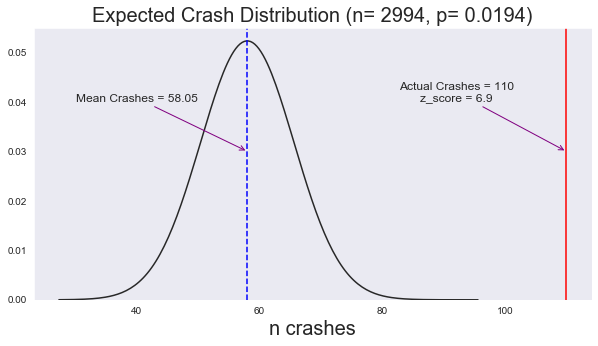

In [47]:
from scipy.stats import norm


n, p = n_experiment, crash_control.mean() # number of trials, probability of each trial
dist = np.random.binomial(n, p, 10000)
mean_crash = dist.mean()
plt.figure(figsize=[10,5])
sns.set_style("dark")


ax = sns.distplot(dist, hist=False, fit=norm, kde=False, label='Normal Distribution of Expected Crashes', color='blue')
plt.title('Expected Crash Distribution (n= {}, p= {:.4f})'.format(n, p), fontsize=20)
ax.set_ylim(0)


#plt.axvline(110, 0, 1, color='red')
plt.axvline(110, 0, 1, color='red', )
plt.axvline(mean_crash, 0, 1, color='blue', linestyle='dashed')

plt.xlabel('n crashes', fontsize=20)

#ax.text(108, 0.045, "Actual n crashes", horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.annotate(s='Actual Crashes = {}\nz_score = {}'.format(110, 6.9),
            xy=(110, 0.03),
            xycoords='data',
            fontsize=12,
            xytext=(-110, 50),
            textcoords='offset points',
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='->', color='purple'),  # Use color black

            )   # New param

ax.annotate(s='Mean Crashes = {:.2f}'.format(mean_crash),
            xy=(mean_crash, 0.03),
            xycoords='data',
            fontsize=12,
            xytext=(-110, 50),
            horizontalalignment='center',
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='purple'),  # Use color black

            )   # New param

Having a cam on is statistically significant for this group.

There could be another effect.  What if the camera that had the most down time also had more crashes.  That would skew the results dramatically

Another way we could this is by going through every camera of interest or by balancing the number of samples taken from each intersection.



## Hypothesis Testing on Individual Cameras

In [48]:
print(select_cams.intersection.unique())
print()
print('We have {} intersections of interest.'.format(len(select_cams.intersection.unique())))

['115TH AND HALSTED' 'FOSTER AND NORTHWEST HIGHWAY'
 'FULLERTON AND NARRAGANSETT' 'HALSTED AND 103RD' 'LAKE AND UPPER WACKER'
 'MICHIGAN AND JACKSON' 'MICHIGAN AND ONTARIO' 'MILWAUKEE AND CENTRAL']

We have 8 intersections of interest.


In [49]:
def print_abtest(intersection, control, experiment):
    '''
    calculates and prints the ttest info for single intersection 
    parameters:
        intersection (str): name of intersection
        control (df): control group (rlc on)
        experiment (df): experiment group (rlc is off)        
    '''
    control = control[control['intersection']==intersection]
    experiment = experiment[experiment['intersection']==intersection]

    
    n_experiment = len(experiment)
    crash_experiment = experiment['crash_record_id'].notnull()

    n_control = len(control)
    crash_control = control['crash_record_id'].notnull()
    
    on_rate = crash_control.mean()
    off_rate = crash_experiment.mean()
    expected_off = on_rate * n_experiment
    
    print()
    print(intersection)
    print('Days on: {}  Days off: {}'.format(n_control, n_experiment))
    
    print('rlc on crash mean: {:.4f}'.format(on_rate))
    print('rlc off crash mean: {:.4f}'.format(off_rate))
    print()

    print('Actual crashes with rlc off:', crash_experiment.sum())
    print('Expected crashes with rlc off: {:.0f}'.format(expected_off))
    
    n = len(crash_experiment)
    p = on_rate
    var = n * p * (1-p)
    std = np.sqrt(var)
    
    print()
    print('SD: {:.2f}'.format(std))  # deviation from expected. We are way outside that
    z_score = (crash_experiment.sum() - expected_off)/std
    print('z score: {:.2f}'.format(z_score))
    
    p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
    print('p_value:', p_val)
    
    if p_val > 0.05: 
        print("Null Hypothesis Not Rejected")
    else:
        print('Null Hypothesis Rejected')
        
    print()
    
    
    if p_val < 0.05: 
        print('Null Hypothesis Rejected')
    else:
        print("Null Hypothesis Not Rejected")
        
    pval_b = stats.binom_test(crash_experiment.sum(),n=len(crash_experiment),p=crash_control.mean())
    print('Binomial Test (pval): {:.4f}'.format(pval_b))

        

experiment = select_cams[select_cams['rlc_on']==0]
control = select_cams[select_cams['rlc_on']==1]
        

for intersection in select_cams.intersection.unique():
    
    control_ = control[control['intersection']==intersection]
    experiment_ = experiment[experiment['intersection']==intersection]

    
    n_experiment = len(experiment_)
    crash_experiment = experiment_['crash_record_id'].notnull()

    n_control = len(control_)
    crash_control = control_['crash_record_id'].notnull()
    
    on_rate = crash_control.mean()
    off_rate = crash_experiment.mean()
    expected_off = on_rate * n_experiment
    
    print()
    print('*'*20)
    print(intersection)
    print()
    
    ab_test(crash_control, crash_experiment, 0.05)
    
    


********************
115TH AND HALSTED

Cameras ON mean: 0.0179
Cameras OFF mean: 0.0318

Actual with rlc off: 38
Expected with rlc off: 21

Standard deviation: 4.58
z score: 3.64

P value: 0.00013

REJECT the null hypothesis

********************
FOSTER AND NORTHWEST HIGHWAY

Cameras ON mean: 0.0082
Cameras OFF mean: 0.0000

Actual with rlc off: 0
Expected with rlc off: 0

Standard deviation: 0.46
z score: -0.46

P value: 0.67824

DO NOT REJECT the null hypothesis

********************
FULLERTON AND NARRAGANSETT

Cameras ON mean: 0.0289
Cameras OFF mean: 0.0263

Actual with rlc off: 1
Expected with rlc off: 1

Standard deviation: 1.03
z score: -0.09

P value: 0.53757

DO NOT REJECT the null hypothesis

********************
HALSTED AND 103RD

Cameras ON mean: 0.0357
Cameras OFF mean: 0.0385

Actual with rlc off: 46
Expected with rlc off: 43

Standard deviation: 6.42
z score: 0.52

P value: 0.30232

DO NOT REJECT the null hypothesis

********************
LAKE AND UPPER WACKER

Cameras 

You can reject the null hypothesis for 2 of 8 intersections which makes it unlikely that these were random occurrances, especially at the p-values obtained. More interesting is that all the expected crashes point in the same direction 

I am not satisfied with these results.  I would like to build a more robust experiment that pools all of our intersections, but maintains some balance between the different intersections.

## Build a balanced experiment and control
We have an imbalance. Each intersection is imbalanced cam_on/cam_off.  We are unable to use all of the data for this reason. If we lump all of the intersections together, the cams that were primarily on or primarily off will be overrepresented in their respective groups.  

I propose balancing every intersection.  If I only have 100 days with the camera off, I will only take 100 days of data from the camera on data.  We should also control for time of year if possible.  We could take random samples perhaps to minimize this effect. 

In [50]:
np.random.seed(0)

balanced_ints_on = pd.Series()
balanced_ints_off = pd.Series()


for myint in select_cams['intersection'].unique():
    myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
    cam_on = myint_df[myint_df.rlc_on==1]
    cam_off = myint_df[myint_df.rlc_on==0]
    cam_on = cam_on.sample(frac=1).reset_index(drop=True)
    cam_off = cam_off.sample(frac=1).reset_index(drop=True)

    
    balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
    if balanced_n:
        print('{:>30}: {}'.format(myint, balanced_n))
    
    # use balanced_n to add same amount to each series
    balanced_ints_on = balanced_ints_on.append(cam_on.iloc[:balanced_n]['crash_record_id'])
    balanced_ints_off = balanced_ints_off.append(cam_off.iloc[:balanced_n]['crash_record_id'])

print()
print(len(balanced_ints_on), 'days of cam on, and', len(balanced_ints_off), 'days of cam off.')
print(balanced_ints_on.count(), balanced_ints_off.count())


balanced_ints_on = balanced_ints_on.notnull()
balanced_ints_off = balanced_ints_off.notnull()


             115TH AND HALSTED: 56
  FOSTER AND NORTHWEST HIGHWAY: 26
    FULLERTON AND NARRAGANSETT: 38
             HALSTED AND 103RD: 56
         LAKE AND UPPER WACKER: 173
          MICHIGAN AND JACKSON: 157
          MICHIGAN AND ONTARIO: 157
         MILWAUKEE AND CENTRAL: 54

717 days of cam on, and 717 days of cam off.
15 33


In [51]:
# after all that, we only have 717 in each dataset for the win.  We only have 8 cameras represented in the set.

In [52]:
ab_test(balanced_ints_on, balanced_ints_off, 0.05)


Cameras ON mean: 0.0209
Cameras OFF mean: 0.0460

Actual with rlc off: 33
Expected with rlc off: 15

Standard deviation: 3.83
z score: 4.70

P value: 0.00000

REJECT the null hypothesis


# Bootstrap resampling method

### Make a balanced data set
Take equal numbers of 'cam on' and 'cam off' data from each intersection of interest.

In [62]:
# # bootstrap resampling
# np.random.seed(42)

# all_ints_on = pd.Series()
# all_ints_off = pd.Series()


# for myint in select_cams['intersection'].unique():
#     myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
#     cam_on = myint_df[myint_df.rlc_on==1]
#     cam_off = myint_df[myint_df.rlc_on==0]
#     cam_on = cam_on.sample(frac=1).reset_index(drop=True)
#     cam_off = cam_off.sample(frac=1).reset_index(drop=True)

    
#     balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
#     if balanced_n:
#         print('{:>30}: {}'.format(myint, balanced_n))
    
#     # use balanced_n to add same amount to each series
#     all_ints_on = all_ints_on.append(cam_on.iloc[:balanced_n]['crash_record_id'])
#     all_ints_off = all_ints_off.append(cam_off.iloc[:balanced_n]['crash_record_id'])

# print()
# print(len(all_ints_on), 'days of cam on, and', len(all_ints_off), 'days of cam off.')
# print(all_ints_on.count(), all_ints_off.count())

In [63]:
def bootstrap(A, B):
    universe = list(A) + list(B)
    universe_shuffled = np.random.choice(universe, size=len(universe), replace=True)
    new_a = universe_shuffled[:len(A)]
    new_b = universe_shuffled[len(A):]
    return new_a, new_b

In [65]:
# bootstrap resampling
np.random.seed(0)

all_ints_on = pd.Series()
all_ints_off = pd.Series()


for myint in select_cams['intersection'].unique():
    myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
    cam_on = myint_df[myint_df.rlc_on==1]
    cam_off = myint_df[myint_df.rlc_on==0]
    cam_on = cam_on.sample(frac=1).reset_index(drop=True)
    cam_off = cam_off.sample(frac=1).reset_index(drop=True)

    
    balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
    if balanced_n:
        print('{:>30}: {}'.format(myint, balanced_n))
    
    # use balanced_n to add same amount to each series
    all_ints_on = all_ints_on.append(cam_on.iloc[:balanced_n]['crash_record_id'])
    all_ints_off = all_ints_off.append(cam_off.iloc[:balanced_n]['crash_record_id'])

print()
print(len(all_ints_on), 'days of cam on, and', len(all_ints_off), 'days of cam off.')
print(all_ints_on.count(), all_ints_off.count())

             115TH AND HALSTED: 56
  FOSTER AND NORTHWEST HIGHWAY: 26
    FULLERTON AND NARRAGANSETT: 38
             HALSTED AND 103RD: 56
         LAKE AND UPPER WACKER: 173
          MICHIGAN AND JACKSON: 157
          MICHIGAN AND ONTARIO: 157
         MILWAUKEE AND CENTRAL: 54

717 days of cam on, and 717 days of cam off.
15 33


In [66]:
exp = balanced_ints_off  # series of True False, did crash occur
con = balanced_ints_on


# bootstrap iterations
iterations = 10**4
diff_mu_a_b = np.mean(exp) - np.mean(con)
num = 0 #Initialize numerator

for n in range(iterations):
    ai, bi = bootstrap(exp, con)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1


p_value = num / iterations
print('P-value: {}'.format(p_value))

print('Camera Off (n_crash):', exp.sum()) 
print('Camera On (n_crash):', con.sum())

P-value: 0.0046
Camera Off (n_crash): 33
Camera On (n_crash): 15


Using the bootstrap resampling method with 10k iterations, we are able to get a very high confidence that the presence of red light cameras reduced crashes at the 9 intersections that were turned on/off.

### Evaluate the power of my t-test. 
I know the number of samples and the means, so I should be able to find the power.
Reminder: power tells us how likely it is that we reject a null hypothesis when it is incorrect.

In [67]:
from statsmodels.stats.power import TTestIndPower, TTestPower

power_analysis = TTestIndPower()

# total days of observations
observations = len(con) + len(exp)
print('Observations: {}'.format(observations))

# effect size is measure of effect (small 02, medium )
effect_size = abs(exp.mean() - con.mean())/ con.std()
print('Effect size: {:.3f}'.format(effect_size) ) # effect size
power = power_analysis.solve_power(effect_size=effect_size, nobs1=observations, alpha=.05)  # nobs1, alpha, power, effect_size
print('Power: {:.3f}'.format(power))

Observations: 1434
Effect size: 0.175
Power: 0.997


The power calculation makes me comfortable that we could even lower the alpha, since we are unlikely to mistakenly reject the null hypothesis when correct.

The effect size is small to medium.

# Same bootstrap resampling t-test with INJURIES 

In [71]:
# bootstrap resampling
np.random.seed(0)

all_ints_on = pd.Series()
all_ints_off = pd.Series()


for myint in select_cams['intersection'].unique():
    myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
    cam_on = myint_df[myint_df.rlc_on==1]
    cam_off = myint_df[myint_df.rlc_on==0]
    cam_on = cam_on.sample(frac=1).reset_index()
    cam_off = cam_off.sample(frac=1).reset_index()

    
    balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
    if balanced_n:
        print('{:>30}: {}'.format(myint, balanced_n))
    
    # use balanced_n to add same amount to each series
    all_ints_on = all_ints_on.append(cam_on.iloc[:balanced_n]['injuries_total'])
    all_ints_off = all_ints_off.append(cam_off.iloc[:balanced_n]['injuries_total'])

print()
print(len(all_ints_on), 'days of cam on, and', len(all_ints_off), 'days of cam off.')
print(all_ints_on.count(), all_ints_off.count())

             115TH AND HALSTED: 56
  FOSTER AND NORTHWEST HIGHWAY: 26
    FULLERTON AND NARRAGANSETT: 38
             HALSTED AND 103RD: 56
         LAKE AND UPPER WACKER: 173
          MICHIGAN AND JACKSON: 157
          MICHIGAN AND ONTARIO: 157
         MILWAUKEE AND CENTRAL: 54

717 days of cam on, and 717 days of cam off.
15 33


In [72]:
exp = all_ints_off.fillna(0)
exp = exp.astype(int)
con = all_ints_on.fillna(0)
con= con.astype(int)

In [73]:
print('Injuries with cams on:  {}'.format(con.sum()))
print('Injuries with cams off: {}'.format(exp.sum()))

Injuries with cams on:  8
Injuries with cams off: 8


In [74]:
# bootstrap iterations
iterations = 10**4
diff_mu_a_b = np.mean(exp) - np.mean(con)
num = 0 #Initialize numerator



for n in range(iterations):
    ai, bi = bootstrap(con, exp)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_value = num / iterations
print('P-value: {}'.format(p_value))

P-value: 0.5268


## Check the results with a built in function

Results here are inconclusisive.  We cannot reject the null hypothesis that red light cameras have no affect on the number of injuries.
It should be noted that there are only 10 and 9 injuries in the dataset.  More data might yield a different result.

In [75]:
from scipy import stats


In [76]:
tStat, pValue = stats.ttest_ind(exp, con, equal_var = False) #run independent sample T-Test
print("P-Value: {:.3f}   T-Statistic: {:.3f}".format(pValue,tStat)) #print the P-Value and the T-Statistic


P-Value: 1.000   T-Statistic: 0.000


## T-test for dangerous crash types
#### Same thing now with types of crashes we are concerned with.  


Start by building a balanced dataset

In [77]:
# bootstrap resampling
np.random.seed(0)

all_ints_on = pd.Series()
all_ints_off = pd.Series()


for myint in select_cams['intersection'].unique():
    myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
    cam_on = myint_df[myint_df.rlc_on==1]
    cam_off = myint_df[myint_df.rlc_on==0]
    cam_on = cam_on.sample(frac=1).reset_index(drop=True)
    cam_off = cam_off.sample(frac=1).reset_index(drop=True)

    
    balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
    if balanced_n:
        print('{:>30}: {}'.format(myint, balanced_n))
    
    # use balanced_n to add same amount to each series
    all_ints_on = all_ints_on.append(cam_on.iloc[:balanced_n]['first_crash_type'])
    all_ints_off = all_ints_off.append(cam_off.iloc[:balanced_n]['first_crash_type'])

print()
print(len(all_ints_on), 'days of cam on, and', len(all_ints_off), 'days of cam off.')
print(all_ints_on.count(), all_ints_off.count())

             115TH AND HALSTED: 56
  FOSTER AND NORTHWEST HIGHWAY: 26
    FULLERTON AND NARRAGANSETT: 38
             HALSTED AND 103RD: 56
         LAKE AND UPPER WACKER: 173
          MICHIGAN AND JACKSON: 157
          MICHIGAN AND ONTARIO: 157
         MILWAUKEE AND CENTRAL: 54

717 days of cam on, and 717 days of cam off.
15 33


In [78]:
all_ints_on.unique()

array([nan, 'TURNING', 'REAR END', 'ANGLE', 'REAR TO SIDE',
       'SIDESWIPE SAME DIRECTION', 'PEDESTRIAN'], dtype=object)

In [79]:
dangerous = ['ANGLE']  # chicago website said this is the one they were trying to prevent.

def targeted_crash_count(crash_type):
    if crash_type in dangerous:
        return 1
    return 0

con = all_ints_on.apply(targeted_crash_count)
exp = all_ints_off.apply(targeted_crash_count)

In [80]:
print('Targeted crashes with cams on:  {}'.format(con.sum()))
print('Targeted crashes with cams off: {}'.format(exp.sum()))

Targeted crashes with cams on:  2
Targeted crashes with cams off: 6


In [81]:
# bootstrap iterations
iterations = 10**4
diff_mu_a_b = np.mean(exp) - np.mean(con)
num = 0 #Initialize numerator



for n in range(iterations):
    ai, bi = bootstrap(con, exp)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_value = num / iterations
print('P-value: {}'.format(p_value))

P-value: 0.1059


Small sample size.  The event was infrequent at best.

In [82]:
tStat, pValue = stats.ttest_ind(exp, con, equal_var = False) #run independent sample T-Test
print("P-Value: {:.3f}   T-Statistic: {:.3f}".format(pValue,tStat)) #print the P-Value and the T-Statistic


P-Value: 0.156   T-Statistic: 1.418


### Power analysis of t-test

In [83]:
from statsmodels.stats.power import TTestIndPower, TTestPower

power_analysis = TTestIndPower()

In [84]:

effect_size = abs(con.mean() - exp.mean())/ exp.std()
print('Effect size:', effect_size)  # effect size


# test has low power, and is unlikely to reject null hypothesis
power = power_analysis.solve_power(effect_size=.01, nobs1=1600, alpha=.05)  # nobs1, alpha, power, effect_size
print('Power:', power )

Effect size: 0.061199306255947106
Power: 0.059208464478414775


# T-test for Rear-end accidents

In [85]:
# bootstrap resampling
np.random.seed(0)

all_ints_on = pd.Series()
all_ints_off = pd.Series()


for myint in select_cams['intersection'].unique():
    myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
    cam_on = myint_df[myint_df.rlc_on==1]
    cam_off = myint_df[myint_df.rlc_on==0]
    cam_on = cam_on.sample(frac=1).reset_index(drop=True)
    cam_off = cam_off.sample(frac=1).reset_index(drop=True)

    
    balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
    if balanced_n:
        print('{:>30}: {}'.format(myint, balanced_n))
    
    # use balanced_n to add same amount to each series
    all_ints_on = all_ints_on.append(cam_on.iloc[:balanced_n]['first_crash_type'])
    all_ints_off = all_ints_off.append(cam_off.iloc[:balanced_n]['first_crash_type'])

print()
print(len(all_ints_on), 'days of cam on, and', len(all_ints_off), 'days of cam off.')
print(all_ints_on.count(), all_ints_off.count())

             115TH AND HALSTED: 56
  FOSTER AND NORTHWEST HIGHWAY: 26
    FULLERTON AND NARRAGANSETT: 38
             HALSTED AND 103RD: 56
         LAKE AND UPPER WACKER: 173
          MICHIGAN AND JACKSON: 157
          MICHIGAN AND ONTARIO: 157
         MILWAUKEE AND CENTRAL: 54

717 days of cam on, and 717 days of cam off.
15 33


In [86]:
dangerous = ['REAR END']  # chicago website said this is the one they were trying to prevent.

def targeted_crash_count(crash_type):
    if crash_type in dangerous:
        return 1
    return 0

con = all_ints_on.apply(targeted_crash_count)
exp = all_ints_off.apply(targeted_crash_count)

In [87]:
print('Rear end crashes with cams on:  {}'.format(con.sum()))
print('Rear end crashes with cams off: {}'.format(exp.sum()))

Rear end crashes with cams on:  1
Rear end crashes with cams off: 4


In [88]:
# bootstrap iterations
iterations = 10**4
diff_mu_a_b = np.mean(exp) - np.mean(con)
num = 0 #Initialize numerator



for n in range(iterations):
    ai, bi = bootstrap(con, exp)
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_value = num / iterations
print('P-value: {}'.format(p_value))

P-value: 0.1315


# Let's try accident types with unbalanced data

In [89]:
experiment = select_cams[select_cams['rlc_on']==0]
control = select_cams[select_cams['rlc_on']==1]

### Angled crashes

In [90]:
exp = experiment['first_crash_type']=='ANGLE'
con = control['first_crash_type']=='ANGLE'

ab_test(con, exp, 0.05)

# binomial test
pval = stats.binom_test(exp.sum(),n=len(exp),p=con.mean())

print('-----')
print('Binomial check: {:.5f}'.format(pval))

Cameras ON mean: 0.0036
Cameras OFF mean: 0.0057

Actual with rlc off: 17
Expected with rlc off: 11

Standard deviation: 3.26
z score: 1.94

P value: 0.02637

REJECT the null hypothesis
-----
Binomial check: 0.06331


### Rear End Crash

In [91]:
print("REAR END ACCIDENTS")
exp = experiment['first_crash_type']=='REAR END'
con = control['first_crash_type']=='REAR END'

ab_test(con, exp, 0.05)

# binomial test
pval = stats.binom_test(exp.sum(),n=len(exp),p=con.mean())

print('-----')
print('Binomial check: {:.5f}'.format(pval))

REAR END ACCIDENTS
Cameras ON mean: 0.0029
Cameras OFF mean: 0.0063

Actual with rlc off: 19
Expected with rlc off: 9

Standard deviation: 2.92
z score: 3.58

P value: 0.00017

REJECT the null hypothesis
-----
Binomial check: 0.00154


This result is surprising, and differs from the Houston study

### Injuries

In [93]:
print("INJURIES")
exp = experiment['injuries_total'].fillna(0).astype(int)
con = control['injuries_total'].fillna(0).astype(int)

ab_test(con, exp, 0.05)

# binomial test
pval = stats.binom_test(exp.sum(),n=len(exp),p=con.mean())

print('-----')
print('Binomial check: {:.5f}'.format(pval))

INJURIES
Cameras ON mean: 0.0090
Cameras OFF mean: 0.0167

Actual with rlc off: 50
Expected with rlc off: 27

Standard deviation: 5.16
z score: 4.47

P value: 0.00000

REJECT the null hypothesis
-----
Binomial check: 0.00006


### Injuries from Angle Crash
This appears to be the limit to our small sample size.  We cannot determine if injuries due to angled crashes is significant.

In [95]:
print("INJURIES FROM ANGLED CRASH")

experiment['injuries_total'] = experiment.apply(lambda x: x.injuries_total if x.first_crash_type=='ANGLE' else 0, axis=1)
exp = experiment['injuries_total'].fillna(0).astype(int)

control['injuries_total'] = control.apply(lambda x: x.injuries_total if x.first_crash_type=='ANGLE' else 0, axis=1)
con = control['injuries_total'].fillna(0).astype(int)

ab_test(con, exp, 0.05)

# binomial test
pval = stats.binom_test(exp.sum(),n=len(exp),p=con.mean())

print('-----')
print('Binomial check: {:.5f}'.format(pval))

INJURIES FROM ANGLED CRASH
Cameras ON mean: 0.0037
Cameras OFF mean: 0.0030

Actual with rlc off: 9
Expected with rlc off: 11

Standard deviation: 3.33
z score: -0.63

P value: 0.73684

DO NOT REJECT the null hypothesis
-----
Binomial check: 0.65148


# Summary
The Hypothesis testing indicates the following:

For the 8 cameras studied:
- fewer accidents and injuries occurred when the cameras were on
- fewer than expected angled crashes and rear end crashes occurred
- in all cameras of interest, there were more than expected crashes with cam off.  
- the presence of cameras have a significant affect on the number of crashes (reduced).
- the presence of cameras have a significant affect on the number of injuries (reduced).
- the presence of cameras have a significant affect on the number of angled crashes (reduced).
- the presence of cameras have a significant affect on the number of rear end crashes (reduced).

The Houston study showed that cameras did not reduce the number of accidents, but rather changed the pattern of traffic accidents.  Rear end collision increased while more dangerous angled crashes decreased.

This study indicates that in Chicago, at least for the 8 intersections in our natural experiment, bothrear end and angled accident types decreased significantly when red light cameras were present.  Injuries were also shown to have a significant decrease.  

In Chicago, for the 8 intersections of interest, red light cameras achieve their stated objective.
